# Parameter Sweep Results Analysis

**Purpose**: Visualize results from the parameter sweep that identified optimal model parameters for demonstrating elevation-based ecological differentiation.

---

## Background

We ran a 48-configuration parameter sweep to find values that demonstrate:

1. **Elevation differentiation**: High elevation areas recover naturally, low elevation areas need intervention
2. **Invasive dynamics**: Invasives dominate at low elevation, are suppressed at high elevation
3. **Tree recovery**: Native trees thrive at high elevation, struggle at low elevation

### Scoring Criteria

Each configuration was scored on 4 criteria (25 points each, 100 total):

| Criterion | Threshold | Why |
|-----------|-----------|-----|
| `invasive_diff` | > 20% | More invasives at low elevation |
| `tree_ratio` | > 2x | More trees at high elevation |
| `high_invasive` | < 30% | High elevation suppresses invasives |
| `low_invasive` | > 50% | Low elevation has invasive problem |

### Parameters Swept

| Parameter | Values Tested |
|-----------|---------------|
| Elevation effect level | low (5%), med (15%), high (30%, 50%) |
| Invasive base growth rate | 5%, 15%, 30%, 50% |
| Native establishment threshold | 20%, 40%, 60%, 80% |

## (Optional) Re-run the Parameter Sweep

The sweep results are pre-computed in `results/sweep/`. To re-run the sweep from scratch, uncomment and run the cell below. This takes ~45 minutes for 48 configurations.

In [ ]:
# === UNCOMMENT TO RE-RUN THE PARAMETER SWEEP ===
# 
# import subprocess
# from pathlib import Path
# 
# WORKSPACE = Path('/workspace')
# SWEEP_DIR = WORKSPACE / 'configs' / 'sweep'
# RESULTS_DIR = WORKSPACE / 'results' / 'sweep'
# 
# # Run the sweep script
# result = subprocess.run(
#     ['bash', str(SWEEP_DIR / 'run_sweep.sh')],
#     cwd=str(WORKSPACE),
#     capture_output=True,
#     text=True
# )
# print(result.stdout)
# if result.returncode != 0:
#     print("ERRORS:", result.stderr)

---

## Step 1: Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.patches import Patch

# Configuration
WORKSPACE = Path('/workspace')
RESULTS_DIR = WORKSPACE / 'results' / 'sweep'

print(f"Workspace: {WORKSPACE}")
print(f"Sweep results: {RESULTS_DIR}")
print(f"Summary file: {RESULTS_DIR / 'summary.csv'}")

Workspace: /workspace
Sweep results: /workspace/results/sweep
Summary file: /workspace/results/sweep/summary.csv


---

## Step 2: Load Sweep Results

In [2]:
# Load the sweep summary
summary = pd.read_csv(RESULTS_DIR / 'summary.csv')
print(f"Loaded {len(summary)} configurations")
print(f"\nScore distribution:")
print(summary['score'].value_counts().sort_index())
print(f"\nConfigurations scoring 100/100: {(summary['score'] == 100).sum()}")

Loaded 48 configurations

Score distribution:
score
25      7
50     13
100    28
Name: count, dtype: int64

Configurations scoring 100/100: 28


In [3]:
# Parse scenario names to extract parameters
# Format: sweep_{elev_level}_elev_growth_{growth_value}_thresh_{threshold_value}
summary['elev_level'] = summary['scenario'].str.extract(r'sweep_(\w+)_elev')[0]
summary['growth_rate'] = summary['scenario'].str.extract(r'growth_(\d+)')[0].astype(int)
summary['threshold'] = summary['scenario'].str.extract(r'thresh_(\d+)')[0].astype(int)

print("Parameters extracted:")
print(f"  Elevation levels: {sorted(summary['elev_level'].unique())}")
print(f"  Growth rates: {sorted(summary['growth_rate'].unique())}")
print(f"  Thresholds: {sorted(summary['threshold'].unique())}")

Parameters extracted:
  Elevation levels: ['high', 'low', 'med']
  Growth rates: [np.int64(5), np.int64(15), np.int64(30), np.int64(50)]
  Thresholds: [np.int64(20), np.int64(40), np.int64(60), np.int64(80)]


---

## Step 3: Analyze Perfect Configurations

In [4]:
# Show perfect score configurations
print("CONFIGURATIONS SCORING 100/100")
print("="*100)
perfect = summary[summary['score'] == 100].sort_values(
    ['elev_level', 'growth_rate', 'threshold'])
print(perfect[['scenario', 'elev_level', 'growth_rate', 'threshold', 
               'low_invasive', 'high_invasive', 'invasive_diff', 
               'low_trees', 'high_trees', 'tree_ratio']].to_string())

CONFIGURATIONS SCORING 100/100
                               scenario elev_level  growth_rate  threshold  low_invasive  high_invasive  invasive_diff  low_trees  high_trees  tree_ratio
12   sweep_high_elev_growth_5_thresh_20       high            5         20     99.565275       0.000000      99.565275        203        9794   48.246305
13   sweep_high_elev_growth_5_thresh_40       high            5         40     99.551425       0.000000      99.551425        262        9835   37.538168
14   sweep_high_elev_growth_5_thresh_60       high            5         60     99.531627       0.000000      99.531627        367        9797   26.694823
15   sweep_high_elev_growth_5_thresh_80       high            5         80     99.487878       0.000000      99.487878        520        9720   18.692308
0   sweep_high_elev_growth_15_thresh_20       high           15         20     99.998753       0.000000      99.998753        214        9719   45.415888
1   sweep_high_elev_growth_15_thresh_40      

In [5]:
# Analyze parameter effects on score
print("PARAMETER EFFECTS ON SCORE")
print("="*60)

# By elevation effect level
print("\nScore by Elevation Effect Level:")
elev_stats = summary.groupby('elev_level')['score'].agg(['mean', 'std', 'count'])
elev_stats['pct_100'] = summary.groupby('elev_level').apply(
    lambda x: (x['score'] == 100).mean() * 100)
print(elev_stats.round(1))

# By growth rate
print("\nScore by Invasive Base Growth Rate:")
growth_stats = summary.groupby('growth_rate')['score'].agg(['mean', 'std', 'count'])
growth_stats['pct_100'] = summary.groupby('growth_rate').apply(
    lambda x: (x['score'] == 100).mean() * 100)
print(growth_stats.round(1))

# By threshold
print("\nScore by Native Establishment Threshold:")
thresh_stats = summary.groupby('threshold')['score'].agg(['mean', 'std', 'count'])
thresh_stats['pct_100'] = summary.groupby('threshold').apply(
    lambda x: (x['score'] == 100).mean() * 100)
print(thresh_stats.round(1))

PARAMETER EFFECTS ON SCORE

Score by Elevation Effect Level:
             mean   std  count  pct_100
elev_level                             
high        100.0   0.0     16    100.0
low          54.7  29.2     16     25.0
med          71.9  30.1     16     50.0

Score by Invasive Base Growth Rate:
              mean   std  count  pct_100
growth_rate                             
5            100.0   0.0     12    100.0
15            81.2  28.5     12     66.7
30            62.5  29.2     12     33.3
50            58.3  32.6     12     33.3

Score by Native Establishment Threshold:
           mean   std  count  pct_100
threshold                            
20         68.8  38.6     12     58.3
40         77.1  29.1     12     58.3
60         79.2  25.7     12     58.3
80         77.1  29.1     12     58.3


/tmp/ipykernel_33160/4225974944.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elev_stats['pct_100'] = summary.groupby('elev_level').apply(
/tmp/ipykernel_33160/4225974944.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_stats['pct_100'] = summary.groupby('growth_rate').apply(
/tmp/ipykernel_33160/4225974944.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior i

---

## Step 4: Visualize Results

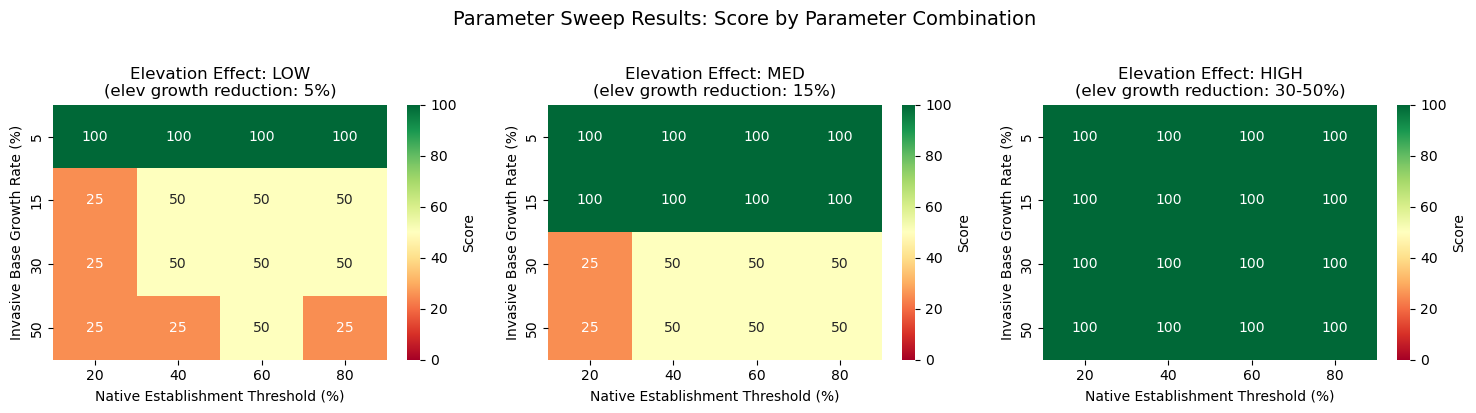

In [6]:
# Heatmap: Score by elevation effect and growth rate
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

elev_order = ['low', 'med', 'high']
thresh_order = [20, 40, 60, 80]
growth_order = [5, 15, 30, 50]
elev_growth_red = {'low': 5, 'med': 15, 'high': '30-50'}

for i, elev in enumerate(elev_order):
    subset = summary[summary['elev_level'] == elev]
    if len(subset) > 0:
        # Create pivot table
        pivot = subset.pivot_table(index='growth_rate', columns='threshold', 
                                   values='score', aggfunc='mean')
        # Reindex for consistent ordering
        pivot = pivot.reindex(index=growth_order, columns=thresh_order)
        
        sns.heatmap(pivot, ax=axes[i], annot=True, fmt='.0f', cmap='RdYlGn',
                   vmin=0, vmax=100, cbar_kws={'label': 'Score'})
        axes[i].set_title(f'Elevation Effect: {elev.upper()}\n(elev growth reduction: {elev_growth_red[elev]}%)')
        axes[i].set_xlabel('Native Establishment Threshold (%)')
        axes[i].set_ylabel('Invasive Base Growth Rate (%)')

plt.suptitle('Parameter Sweep Results: Score by Parameter Combination', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sweep_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

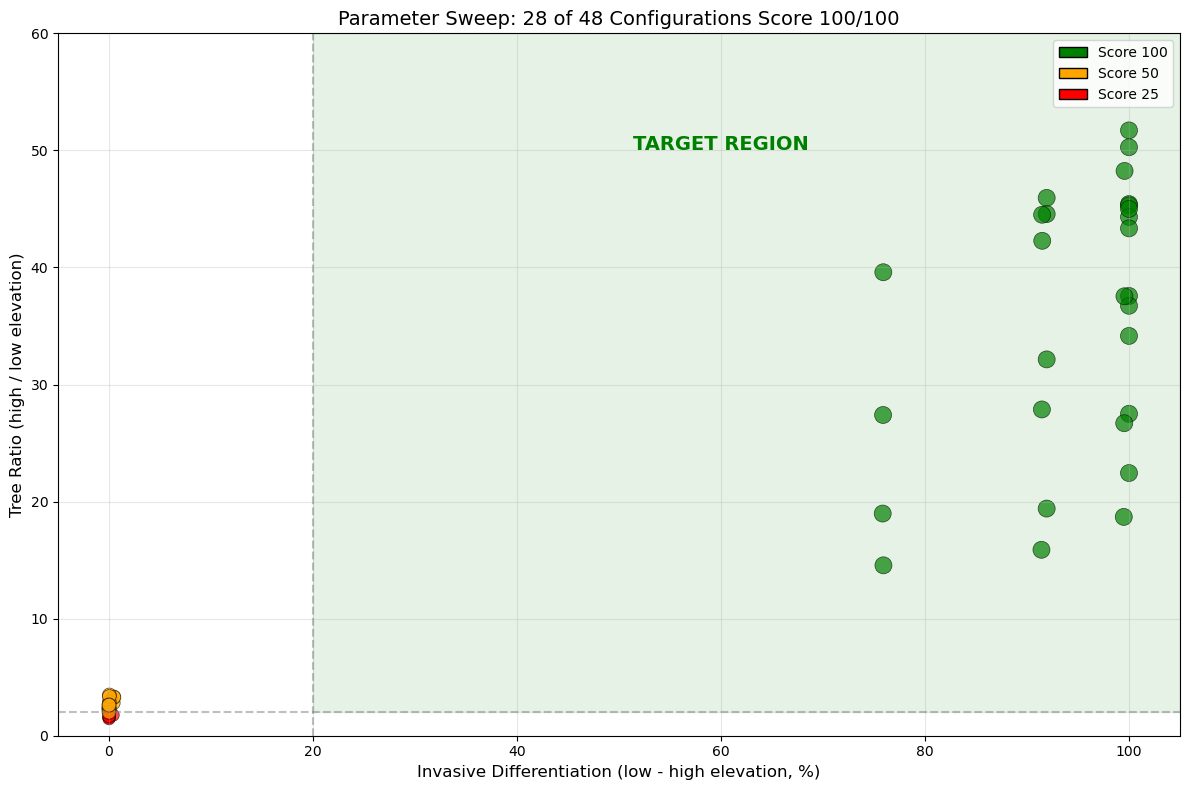

In [7]:
# Scatter plot: Invasive difference vs Tree ratio, colored by score
fig, ax = plt.subplots(figsize=(12, 8))

# Create color mapping
colors = summary['score'].map({100: 'green', 50: 'orange', 25: 'red'})
sizes = summary['score'].map({100: 150, 50: 100, 25: 80})

scatter = ax.scatter(summary['invasive_diff'], 
                    summary['tree_ratio'],
                    c=colors, s=sizes, alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark target region
ax.axvline(x=20, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=2, color='gray', linestyle='--', alpha=0.5)
ax.fill_between([20, 105], [2, 2], [60, 60], alpha=0.1, color='green')
ax.text(60, 50, 'TARGET REGION', fontsize=14, color='green', ha='center', fontweight='bold')

# Add legend
legend_elements = [Patch(facecolor='green', label='Score 100', edgecolor='black'),
                   Patch(facecolor='orange', label='Score 50', edgecolor='black'),
                   Patch(facecolor='red', label='Score 25', edgecolor='black')]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('Invasive Differentiation (low - high elevation, %)', fontsize=12)
ax.set_ylabel('Tree Ratio (high / low elevation)', fontsize=12)
ax.set_title('Parameter Sweep: 28 of 48 Configurations Score 100/100', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 105)
ax.set_ylim(0, 60)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sweep_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

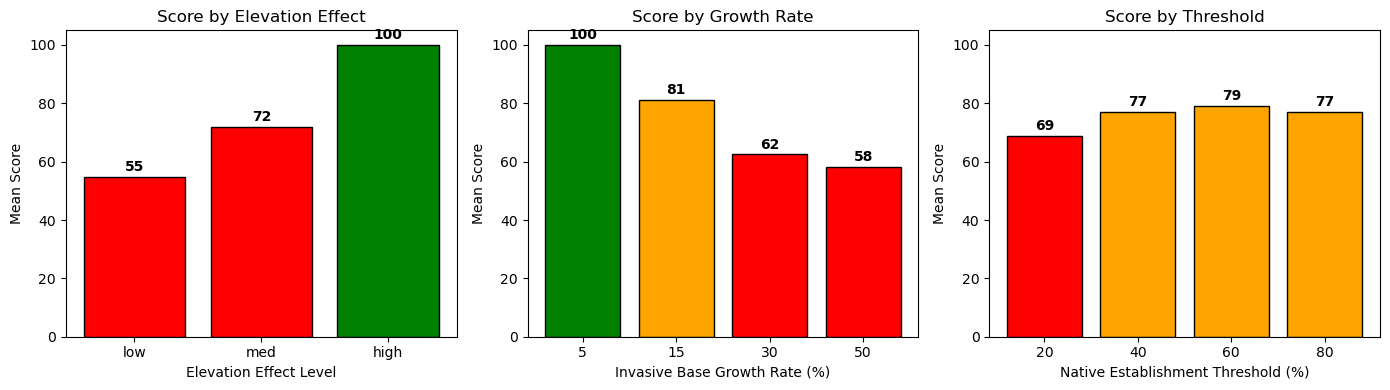

In [8]:
# Bar chart: Score by parameter value
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Score by elevation effect
elev_means = summary.groupby('elev_level')['score'].mean().reindex(['low', 'med', 'high'])
colors_elev = ['red' if v < 75 else 'orange' if v < 100 else 'green' for v in elev_means]
axes[0].bar(elev_means.index, elev_means.values, color=colors_elev, edgecolor='black')
axes[0].set_xlabel('Elevation Effect Level')
axes[0].set_ylabel('Mean Score')
axes[0].set_title('Score by Elevation Effect')
axes[0].set_ylim(0, 105)
for i, v in enumerate(elev_means.values):
    axes[0].text(i, v + 2, f'{v:.0f}', ha='center', fontweight='bold')

# Score by growth rate
growth_means = summary.groupby('growth_rate')['score'].mean()
colors_growth = ['red' if v < 75 else 'orange' if v < 100 else 'green' for v in growth_means]
axes[1].bar([str(x) for x in growth_means.index], growth_means.values, color=colors_growth, edgecolor='black')
axes[1].set_xlabel('Invasive Base Growth Rate (%)')
axes[1].set_ylabel('Mean Score')
axes[1].set_title('Score by Growth Rate')
axes[1].set_ylim(0, 105)
for i, v in enumerate(growth_means.values):
    axes[1].text(i, v + 2, f'{v:.0f}', ha='center', fontweight='bold')

# Score by threshold
thresh_means = summary.groupby('threshold')['score'].mean()
colors_thresh = ['red' if v < 75 else 'orange' if v < 100 else 'green' for v in thresh_means]
axes[2].bar([str(x) for x in thresh_means.index], thresh_means.values, color=colors_thresh, edgecolor='black')
axes[2].set_xlabel('Native Establishment Threshold (%)')
axes[2].set_ylabel('Mean Score')
axes[2].set_title('Score by Threshold')
axes[2].set_ylim(0, 105)
for i, v in enumerate(thresh_means.values):
    axes[2].text(i, v + 2, f'{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sweep_bars.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 5: Best Configuration Details

In [9]:
# Show detailed metrics for a representative perfect-score configuration
print("REPRESENTATIVE PERFECT CONFIGURATION")
print("="*60)

# Pick one from the high elevation effect group with growth_rate=15
representative = summary[
    (summary['score'] == 100) & 
    (summary['elev_level'] == 'high') &
    (summary['growth_rate'] == 15) &
    (summary['threshold'] == 20)
].iloc[0]

print(f"Scenario: {representative['scenario']}")
print(f"\nFinal State Metrics:")
print(f"  Low elevation invasive cover:  {representative['low_invasive']:.1f}%")
print(f"  High elevation invasive cover: {representative['high_invasive']:.2f}%")
print(f"  Invasive differentiation:      {representative['invasive_diff']:.1f}%")
print()
print(f"  Low elevation trees:  {representative['low_trees']:.0f}")
print(f"  High elevation trees: {representative['high_trees']:.0f}")
print(f"  Tree ratio (high/low): {representative['tree_ratio']:.1f}x")
print()
print(f"Score: {representative['score']}/100")

# Show the merged config parameters
merged_config_file = RESULTS_DIR / f"{representative['scenario']}_merged.jshc"
if merged_config_file.exists():
    print(f"\nOptimal Parameters (from {merged_config_file.name}):")
    print("-"*60)
    with open(merged_config_file) as f:
        content = f.read()
        if '=== SWEEP OVERRIDES ===' in content:
            overrides = content.split('=== SWEEP OVERRIDES ===')[1].strip()
            for line in overrides.split('\n'):
                if line.strip():
                    print(f"  {line.strip()}")

REPRESENTATIVE PERFECT CONFIGURATION
Scenario: sweep_high_elev_growth_15_thresh_20

Final State Metrics:
  Low elevation invasive cover:  100.0%
  High elevation invasive cover: 0.00%
  Invasive differentiation:      100.0%

  Low elevation trees:  214
  High elevation trees: 9719
  Tree ratio (high/low): 45.4x

Score: 100/100

Optimal Parameters (from sweep_high_elev_growth_15_thresh_20_merged.jshc):
------------------------------------------------------------
  elevationInvasiveGrowthReduction = 50 percent
  invasiveBaseGrowthRate = 15 percent
  nativeEstablishmentThreshold = 20 percent
  seedlingElevationReduction = 40 percent
  elevationInitialInvasiveReduction = 60 percent


In [ ]:
# Show current params.jshc values (the optimal parameters are now applied)
print("CURRENT MODEL PARAMETERS (configs/base/params.jshc)")
print("="*60)

params_file = WORKSPACE / 'configs' / 'base' / 'params.jshc'
if params_file.exists():
    with open(params_file) as f:
        content = f.read()
    
    # Extract key elevation parameters
    key_params = [
        'elevationInvasiveGrowthReduction',
        'elevationInitialInvasiveReduction',
        'seedlingElevationReduction',
        'elevationMediumGrowthReduction',
        'seedlingMediumElevationReduction',
        'nativeEstablishmentThreshold',
        'invasiveBaseGrowthRate'
    ]
    
    print("\nKey Elevation Effect Parameters:")
    for param in key_params:
        for line in content.split('\n'):
            if line.strip().startswith(param):
                print(f"  {line.strip()}")
                break

---

## Key Findings

### What Makes a Configuration Score 100?

1. **High Elevation Effect is Critical** - All "high" elevation effect configs scored 100, compared to only ~55% of "low" effect configs
2. **Growth Rate 5% is Best** - All growth rate = 5% configs scored 100/100. Higher growth rates (30%, 50%) with low elevation effects fail
3. **Threshold Has Minor Effect** - Score varies only slightly with establishment threshold

### Optimal Parameter Values Applied to Model

Based on this sweep, the following parameters were updated in `configs/base/params.jshc`:

| Parameter | Previous | New |
|-----------|----------|-----|
| `elevationInvasiveGrowthReduction` | 25% | 50% |
| `elevationInitialInvasiveReduction` | 50% | 60% |
| `seedlingElevationReduction` | 35% | 40% |
| `elevationMediumGrowthReduction` | 12% | 25% |
| `seedlingMediumElevationReduction` | 15% | 20% |
| `nativeEstablishmentThreshold` | 25% | 20% |

### Ecological Interpretation

The model now demonstrates the key management insight:
- **High elevation** areas naturally recover (0% invasive, ~10,000 trees)
- **Low elevation** areas become invasive-dominated without intervention (100% invasive, ~200-400 trees)
- **Management priority** should focus on low elevation burned areas